In [1]:
!git clone https://github.com/Shulin-Zhang/pytorch_models.git > /dev/null 2>&1
!echo y | conda install pytorch==1.3.0 -c pytorch > /dev/null 2>&1

In [2]:
from collections import Counter
import os

import numpy as np
from matplotlib import pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler 
from torch.utils.data import Dataset, DataLoader

from pytorch_models.utils.lr_finder import Lr_finder

np.random.seed(100)
torch.manual_seed(100)

torch.__version__

'1.3.0'

In [3]:
raw_data_path = 'pytorch_models/couplet_generation/data/all_couplets.txt'
vocabs_size = 1000

### 划分数据集

In [4]:
def split_dataset(raw_data_path, test_size=3000):
    with open(raw_data_path, 'r') as f:
        lines = f.readlines()
        
    lines = list(map(str.strip, lines))
    
    np.random.shuffle(lines)
    
    train_lines = lines[test_size:]
    test_lines = lines[:test_size]
        
    return train_lines, test_lines

In [5]:
train_lines, test_lines = split_dataset(raw_data_path, test_size=3000)

len(train_lines), len(test_lines)

(771491, 3000)

### 获取字符表

In [6]:
def create_vocabs(train_lines, size=-1):
    counter = Counter(''.join(train_lines))
    vocabs = sorted(counter, key=lambda c: counter[c], reverse=True)
    
    if size != -1:
        vocabs = vocabs[:size]
    
    print(f"last character: {vocabs[-1]}, frequency: {counter[vocabs[-1]]}")
        
    return vocabs

In [7]:
vocabs = create_vocabs(train_lines, size=vocabs_size)

last character: 律, frequency: 2808


In [8]:
def create_index_char(vocabs):
    chars = vocabs.copy()
    chars = ['unk', ' ', 'bos'] + chars

    return dict(zip(range(0, len(chars)), chars)), dict(zip(chars, range(0, len(chars))))

In [9]:
index2char, char2index = create_index_char(vocabs)

### 创建数据集

In [10]:
class Couplets_dataset(Dataset):
    def __init__(self, lines, char2index, min_len=10, max_len=20):
        index_list = []
        
        for line in lines:
            if len(line) < min_len:
                continue
                
            stop_char_index = line.index('。')
            if stop_char_index > max_len - 1:
                continue
            
            indexs = [char2index.get(c, char2index['unk']) for c in line]
            
            padding = max_len - len(indexs)
            if padding > 0:
                indexs += [char2index[' ']] * padding
                
            index_list.append(indexs)
            
        self.data = torch.tensor(index_list)
        self.eye = torch.eye(len(char2index))
        
    def __getitem__(self, index):
        y = self.data[index]
        x = torch.cat([torch.tensor([0]), y[:-1]])
        return self.eye[x], y
    
    def __len__(self):
        return self.data.size(0)

In [11]:
train_set = Couplets_dataset(train_lines, char2index, max_len=30)
test_set = Couplets_dataset(test_lines, char2index, max_len=30)

In [12]:
len(train_set), len(test_set)

(646798, 2506)

In [13]:
train_loader = DataLoader(train_set, batch_size=512, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=512, shuffle=False, num_workers=4)

### 创建LSTM网络

In [14]:
class Couplets_net(nn.Module):
    
    def __init__(self, vocabs_size, hidden_dim=300):
        super().__init__()
        
        self.vocabs_size = vocabs_size
        self.hidden_dim = hidden_dim
                
        self.lstm_cell_0 = nn.LSTMCell(vocabs_size, hidden_dim)
        self.lstm_cell_1 = nn.LSTMCell(hidden_dim, hidden_dim)
        self.fc_1 = nn.Linear(hidden_dim, vocabs_size)
        
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.LSTMCell):
                nn.init.xavier_normal_(m.weight_hh)
                nn.init.xavier_normal_(m.weight_ih)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, X):           
        h_0 = torch.zeros(X.size(0), self.hidden_dim)
        c_0 = torch.zeros(X.size(0), self.hidden_dim)
        h_1 = torch.zeros(X.size(0), self.hidden_dim)
        c_1 = torch.zeros(X.size(0), self.hidden_dim)
        if torch.cuda.is_available():
            h_0, c_0, h_1, c_1 = h_0.to('cuda'), c_0.to('cuda'), h_1.to('cuda'), c_1.to('cuda')
        
        Y_out = []
        
        for i in range(X.size(1)):
            X_step = X[:, i]
                        
            h_0, c_0 = self.lstm_cell_0(X_step, (h_0, c_0))
            h_1, c_1 = self.lstm_cell_1(h_0, (h_1, c_1))
            X_step = self.fc_1(h_1)
            
            Y_out.append(X_step)
            
        return torch.stack(Y_out).transpose(0, 1)
    
    def sample(self, stop_index):
        X_step = torch.zeros(1, self.vocabs_size)
        
        h_0 = torch.zeros(1, self.hidden_dim)
        c_0 = torch.zeros(1, self.hidden_dim)
        h_1 = torch.zeros(1, self.hidden_dim)
        c_1 = torch.zeros(1, self.hidden_dim)
        if torch.cuda.is_available():
            X_step = X_step.to('cuda')
            h_0, c_0, h_1, c_1 = h_0.to('cuda'), c_0.to('cuda'), h_1.to('cuda'), c_1.to('cuda')
        
        Y_out = []
        
        while True:            
            h_0, c_0 = self.lstm_cell_0(X_step, (h_0, c_0))
            h_1, c_1 = self.lstm_cell_1(h_0, (h_1, c_1))
            X_step = self.fc_1(h_1)
            X_step = nn.functional.softmax(X_step, dim=-1)
            X_step[:, char2index['unk']] = 0
            out_index = torch.multinomial(X_step, 1).squeeze().cpu().item()
            Y_out.append(out_index)
            
            X_step = torch.zeros(1, self.vocabs_size)
            X_step[:, out_index] = 1
            
            if torch.cuda.is_available():
                X_step = X_step.to('cuda')
            
            if out_index == stop_index:
                break    
            
        return np.array(Y_out)

In [15]:
model = Couplets_net(len(char2index))

### 搜索最大学习率

In [16]:
def create_loss():
    loss_fn = nn.CrossEntropyLoss()

    def new_loss_fn(outputs, labels):
        outputs = outputs.reshape((-1, outputs.size(-1)))
        labels = labels.reshape((-1))
        loss = loss_fn(outputs, labels)
        return loss
    
    return new_loss_fn

In [17]:
lr_finder = Lr_finder(model, train_loader, create_loss(), optim.SGD(model.parameters(), 0.1, weight_decay=0))

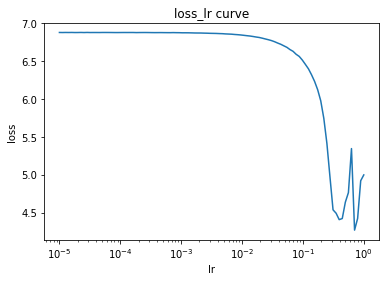

In [18]:
lr_finder.lr_find(steps=100, lr_range=(1e-5, 1), plot=True, repeat=2)

### 训练

In [19]:
class Learner:
    def __init__(self, model):
        if torch.cuda.is_available():
            self.model = model.to('cuda')
        else:
            self.model = model

    def fit(self, dataloader, lr, epochs, weight_decay=0, print_steps=200):
        self.model.train()

        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr, momentum=0.9,
                              weight_decay=weight_decay, nesterov=False)
        scheduler = lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs,
                                            steps_per_epoch=len(dataloader))

        history_loss = []
        history_steps = []
        for epoch in range(epochs):
            for step, (X, Y) in enumerate(dataloader):
                if torch.cuda.is_available():
                    X, Y = X.to('cuda'), Y.to('cuda')

                outputs = self.model(X)
                outputs = outputs.reshape((-1, outputs.size(-1)))
                Y = Y.reshape((-1))
                loss = loss_fn(outputs, Y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                if step % print_steps == print_steps - 1:
                    history_loss.append(loss.item())
                    history_steps.append(epoch * len(dataloader) + step + 1)
                    print(f"epoch: {epoch + 1}    \tstep: {step + 1}    \tloss: {loss:.4f}")

        return history_steps, history_loss

    def evaluate(self, dataloader):
        self.model.eval()
        
        loss_fn = nn.CrossEntropyLoss()

        losses = []

        with torch.no_grad():
            for X, Y in dataloader:
                if torch.cuda.is_available():
                    X, Y = X.to('cuda'), Y.to('cuda')

                outputs = self.model(X)
                outputs = outputs.reshape((-1, outputs.size(-1)))
                Y = Y.reshape((-1))
                loss = loss_fn(outputs, Y)
                losses.append(loss.item())

        return np.average(losses)
    
    def sample(self, times=8):
        self.model.eval()
        
        with torch.no_grad():
            for _ in range(times):
                samples = self.model.sample(char2index['。'])
                chars = [index2char[index] for index in samples]
                sentence = ''.join(chars)
            
                print(sentence)

In [20]:
learn = Learner(model)

In [21]:
history_steps, history_loss = learn.fit(train_loader, 0.3, 20, weight_decay=0, print_steps=200)

epoch: 1    	step: 200    	loss: 3.5779
epoch: 1    	step: 400    	loss: 3.3832
epoch: 1    	step: 600    	loss: 3.4050
epoch: 1    	step: 800    	loss: 3.3339
epoch: 1    	step: 1000    	loss: 3.2023
epoch: 1    	step: 1200    	loss: 3.2308
epoch: 2    	step: 200    	loss: 3.0990
epoch: 2    	step: 400    	loss: 3.1439
epoch: 2    	step: 600    	loss: 3.1223
epoch: 2    	step: 800    	loss: 3.0203
epoch: 2    	step: 1000    	loss: 3.0295
epoch: 2    	step: 1200    	loss: 3.0252
epoch: 3    	step: 200    	loss: 3.3552
epoch: 3    	step: 400    	loss: 3.0915
epoch: 3    	step: 600    	loss: 3.2685
epoch: 3    	step: 800    	loss: 3.1497
epoch: 3    	step: 1000    	loss: 3.0683
epoch: 3    	step: 1200    	loss: 3.0059
epoch: 4    	step: 200    	loss: 3.0119
epoch: 4    	step: 400    	loss: 3.9632
epoch: 4    	step: 600    	loss: 3.0502
epoch: 4    	step: 800    	loss: 3.0160
epoch: 4    	step: 1000    	loss: 3.0066
epoch: 4    	step: 1200    	loss: 2.9836
epoch: 5    	step: 200    	loss:

Text(0, 0.5, 'loss')

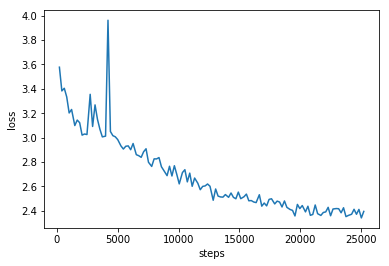

In [22]:
plt.plot(history_steps, history_loss)
plt.xlabel('steps')
plt.ylabel('loss')

In [23]:
learn.evaluate(test_loader)

2.382068395614624

In [26]:
learn.sample(times=20)

黄叶驰生风，开怀春是梅；院安中华夏，景润艳描美。
看日而三春，山川晚满随风梦；同归倾百意，竹叶含情冷雨年。
独胆庄行云赤历；长城洗醉月青山。
敢崇丹名养头，只思不见；空长偶归天而，要武当行。
一盏出人去；几间来月来。
湖天共不移，心激过处天发展；处事无穷妙？曲润须山处处传。
英雄北斗千秋史；秀宇河山四海春。
久隐破、天南晓，谁而想日；草连春去、秋潮、喜好大开。
美谷无如，龙呈虎卷多博古；百人有道，不耕霜园第约香。
画骏图飞，越汉功越呈盛会；名南河秀，长山异祖展华才。
若一方，霜不过，何所近药；登道海，无正世，也可直乎。
凝志逢春，冬盏梅香写意；才诚致凤，风开画卷升云。
墨翠群青三环笔；波临九州四面红。
正气兴春，难古怀新辉寿月；明泉狂我，共呼慈万和乾坤。
水沐青灯，千载历丝弹入任；刀纷胜雨，孤歌诗韵尽成他。
善愁和至多来少；梦乐天圆一字多。
八千年锦绣人，回启大业；玉千万里心涌，正听骚民。
吟辉福地三春暖；华夏铸身万户欢。
物伴新临满前寿；春和共顺幸福时。
水月寒摇，四海山光明入海；莺歌赋绿，千年秋月尽名魂。
